In [1]:
import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import matplotlib.pyplot as plt
from pykalman import KalmanFilter
import statistics
import seaborn as sns; sns.set(style="whitegrid")
import math
%run Cointegration.py
%matplotlib inline

In [16]:
def coefficients(y, x, period):
    model = regression(y, x, period)
    return {"temp":model.params['temp'],
            "angular":model.params['x'],
            "intercept":model.params['const']}

def regression(y, x, period):
    y, x = get_values(y, x, period)
    pairs = pd.DataFrame()
    
    pairs['y'] = y
    pairs['x'] = x

    pairs['temp'] = timeline(period)
    
    x = pairs[['x', 'temp']]
    x = sm.add_constant(x)
    model = sm.OLS(pairs['y'], x).fit()
    return model

def resid(y, x, period):
    coef = coefficients(y, x, period)
    temp = timeline(period)
    res = y-coef['angular']*x-temp*coef['temp']-coef['intercept']
    #res[0]=0
    return res

def timeline(period):
    numbers = np.arange(1, period+1)
    temp = period - numbers + 1
    return temp

def lot(y_lot, coef):
    return [y_lot, int(y_lot*coef['angular'])]

def return_ln(y, x, period):
    y, x = get_values(y, x, period)
    y_log = np.log(y/y.shift(1))
    x_log = np.log(x/x.shift(1))
    return [y_log, x_log]
    
def get_values(y, x, period):
    if(period <= 0):
        return y, x
    
    y = y.iloc[:period]
    x = x.iloc[:period]
    return y, x

def corr(y, x, period):
    per_y, per_x = return_ln(y, x, period)
    return per_y.corr(per_x)

def getdata(data, period):
    data_max = data[:period]
    return data_max

def diff_ratio(y, x, period):
    y, x = get_values(y, x, period)
    coef = coefficients(y, x, period)
    res = resid(y, x, period)
    diff = res.shift(1)-res
    diff[0]=0
    return diff

def ratio_continuo(y, x, period):
    y, x = get_values(y, x, period)
    ratio = y-x
    return ratio
    
def intercept_coef(y, x, period):
    y, x = get_values(y, x, period)
    coef = coefficients(y, x, period)
    res = resid(y, x, period)
    diff = diff_ratio(y, x, period)

    target = pd.DataFrame(res, columns=["target"])
    target = sm.add_constant(target)
    model = sm.OLS(diff, target).fit()
    return model.params['target']

def intercept_inter(y, x, period):
    ratio_cont = ratio_continuo(y, x, period)
    ratio_cont[0]=0
    diff_r = diff_ratio(y, x, period)
    
    ratio_cont = sm.add_constant(ratio_cont)
    model = sm.OLS(diff_r, ratio_cont).fit()
    return model.params['const']

def ornstein_hulenbeck(y, x, period):
    coef = intercept_coef(y, x, period)
    
    beta = -np.log(1+intercept_coef(y, x, period))
    alpha = -(coef/intercept_inter(y, x, period))
    
    std = resid(y, x, period).std()
    sigma=std*np.sqrt(np.log(1+coef)/(np.power((1+coef),2)-1))
    
    half = 2/beta
    return {
        "halffile": half,
        "beta": beta,
        "alpha": alpha,
        "sigma": sigma
    }

def estatisticas(y, x, period):
    res = resid(y, x, period)
    std = res.std()
    return {
        "std": std,
        "std_up": 2*std,
        "std_down": -2*std,
        "mean": res.mean(),
        "min": np.min(res)-2*std,
        "max": np.max(res)+2*std
    }

def stop_calc(y, x, period):
    res = resid(y, x, period)
    
    # acima do quadro "ESTATÍSTICAS"
    std_down = res.mean()-3.1*res.std()
    std_up = res.mean()+3.1*res.std()
    
    est = coefficients(y, x, period)
    l_res = resid(y, x, period)[0]
    price = x[0]
    
    value1 = (price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))/price
    value2 = price/(price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))
    return max(value1, value2)

def output_calc(y, x, period):
    price = x[0]
    est = coefficients(y, x, period)
    value1 = (est['angular']*price+est['intercept']+est['temp']*period)/price
    value2 = 1/((est['angular']*price+est['intercept']+est['temp']*period)/price)
    return max(value1, value2)

def input_calc(y, x, period):
    price = x[0]
    res = resid(y, x, period)
    l_res = res[0]
    est = coefficients(y, x, period)
    std_up = 2*res.std()
    std_down = -2*res.std()

    value1 = (price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))/price
    value2 = price/(price*est['angular']+est['intercept']+l_res+est['temp']*period+min(l_res-std_down,std_up-l_res)*sinal(l_res))
    return max(value1, value2)

def loss_percent(y, x, period):
    return -abs(stop_calc(y, x, period)/input_calc(y, x, period)-1)

def current_percent(y, x, period):
    ratio_current = y[0]/x[0]
    v = 1/ratio_current
    return abs(output_calc(y, x, period)/max(ratio_current,v)-1)

def retorno_percent(y, x, period):
    return abs(output_calc(y, x, period)/input_calc(y, x, period)-1)

def loss_value(y, x, lot, period):
    return y[0]*lot*loss_percent(y, x, period)

def take_value(y, x, lot, period):
    return current_percent(y, x, period)*lot*y[0]
    
def sinal(value):
    if(value < 0):
        return -1
    return 1

In [96]:
#'CYRE3', 'LREN3
y_symbol = 'ABEV3'
x_symbol = 'BBAS3'
period = 250

In [97]:
y, x = get_values(data[y_symbol], data[x_symbol],period)

In [98]:
print('corr: {}'.format(corr(y, x, period)))
print('stop_calc: {}'.format(stop_calc(y, x, period)))
print('output_calc: {}'.format(output_calc(y, x, period)))
print('input_calc: {}'.format(input_calc(y, x, period)))
print('loss_percent: {}'.format(loss_percent(y, x, period)*100))
print('current_percent: {}'.format(current_percent(y, x, period)*100))
print('retorno_percent: {}'.format(retorno_percent(y, x, period)*100))
print('loss_value: {}'.format(loss_value(y, x, 1000, period)))
print('take_value: {}'.format(take_value(y, x, 1000, period)))
print('intercept_coef: {}'.format(intercept_coef(y, x, period)))
print('intercept_inter: {}'.format(intercept_inter(y, x, period)))

corr: 0.5528102942708933
stop_calc: 2.0955308890085584
output_calc: 2.5940063400036153
input_calc: 2.2488757379977793
loss_percent: -6.818733752081252
current_percent: 12.639646333389521
retorno_percent: 15.346806236306909
loss_value: -979.1701667988677
take_value: 1815.053213474735
intercept_coef: -0.07803861542944583
intercept_inter: -0.047316846765560375


In [61]:
estatisticas(y, x, period)

{'std': 0.8410095522237859,
 'std_up': 1.6820191044475719,
 'std_down': -1.6820191044475719,
 'mean': -7.013056801952189e-15,
 'min': -3.5405695163188975,
 'max': 3.8034284475112026}

In [88]:
ornstein_hulenbeck(y, x, period)

{'halffile': 32.128294429769674,
 'beta': 0.06225042553602923,
 'alpha': 1.1733288379837536,
 'sigma': 0.6132862274913455}

In [90]:
coef = coefficients(y, x, period)
coef

{'temp': -0.014685227954364756,
 'angular': 0.11740455350833821,
 'intercept': 13.483145524510206}

In [94]:
data = pd.read_csv('datasets/data_cart.csv', index_col=0)
data = data[::-1]
data
#data.drop(['30/06/2020'], inplace=True)

,ABEV3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,BPAC11,BRAP4,...,SUZB3,TAEE11,TIMP3,TOTS3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3
Data,,,,,,,,,,,,,,,,,,,,,
01/07/2020,14.36,20.67,56.03,33.07,19.28,21.16,27.70,12.84,76.50,35.44,...,37.14,28.49,14.47,23.75,18.80,7.34,54.54,48.08,15.99,52.59
30/06/2020,14.14,20.11,55.09,32.15,18.96,20.70,27.27,13.15,76.50,36.51,...,36.79,28.10,14.20,23.15,18.38,7.27,55.92,48.03,15.31,50.61
29/06/2020,14.26,20.73,54.96,33.44,19.56,21.41,28.25,12.96,76.00,36.34,...,37.73,28.67,13.77,22.42,18.00,7.15,55.63,48.20,15.38,49.92
26/06/2020,13.95,20.00,53.45,31.82,19.08,20.69,27.85,12.79,72.67,36.43,...,37.88,28.07,14.03,22.26,17.64,7.10,55.62,48.54,14.29,50.00
25/06/2020,14.18,21.20,55.00,33.01,19.63,21.35,29.00,12.95,76.90,36.97,...,38.08,28.30,14.20,23.07,18.31,7.29,56.00,49.31,14.55,49.22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24/04/2019,17.72,33.48,33.50,48.31,31.01,35.65,27.80,7.95,39.67,31.71,...,41.69,26.31,11.87,43.20,21.38,8.59,50.36,46.46,3.93,18.80
23/04/2019,17.67,34.17,32.84,49.31,31.00,35.89,27.62,7.99,39.45,32.65,...,41.01,26.15,12.06,42.79,22.55,8.91,51.92,47.00,3.93,19.25
22/04/2019,17.50,33.98,31.95,48.34,30.44,35.04,27.59,7.34,38.00,32.35,...,40.65,26.29,12.16,41.60,22.19,8.97,51.30,46.95,3.84,18.75


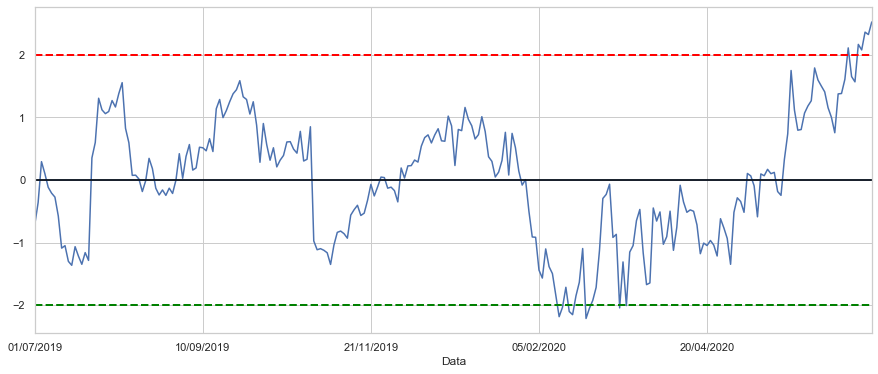

In [68]:
res = resid(data_limmit[y_symbol], data_limmit[x_symbol], period)
# antes de plotar os dados devem ser invertidos para ordem crescente
ret = zscore(res[::-1])
std = statistics.stdev(ret)
ret.plot(figsize=(15,6))
plt.axhline(ret.mean())

plt.axhline(0, color='black',label='mean') # Add the mean of residual
plt.axhline(2*std, color='red', linestyle='--', linewidth=2)
plt.axhline(-2*std, color='green', linestyle='--', linewidth=2)

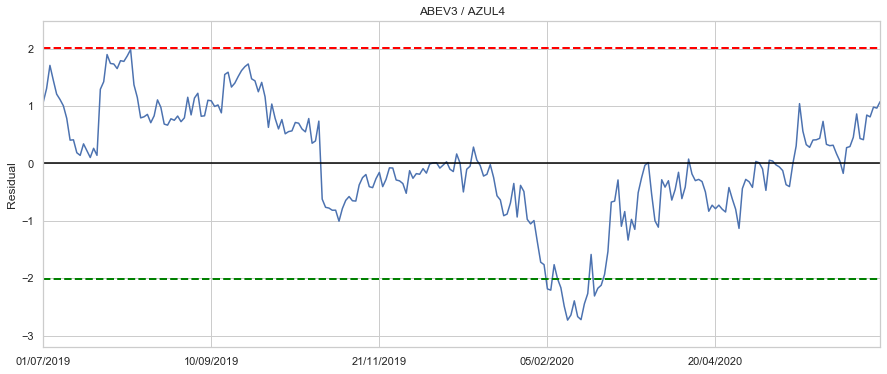

In [51]:
show(data[::-1], y_symbol, x_symbol, period)

In [18]:
"""zscore(model.resid)[::-1].plot(figsize=(15,6))"""

'zscore(model.resid)[::-1].plot(figsize=(15,6))'

In [385]:
"""coef_temp = -0.0003
coef_ang = 0.141
coef_linear = 9.97

#data['resid'] = data['BBAS3']-coef_ang*data['CSAN3']-data['Du']*coef_temp-coef_linear
resid = data_limmit[y_symbol]-coef_ang*data_limmit[x_symbol]-data_limmit['Du']*coef_temp-coef_linear
resid = resid[::-1]"""

"coef_temp = -0.0003\ncoef_ang = 0.141\ncoef_linear = 9.97\n\n#data['resid'] = data['BBAS3']-coef_ang*data['CSAN3']-data['Du']*coef_temp-coef_linear\nresid = data_limmit[y_symbol]-coef_ang*data_limmit[x_symbol]-data_limmit['Du']*coef_temp-coef_linear\nresid = resid[::-1]"